# Avance 2 — Ingeniería de Características (FE) + Selección/Extracción (CRISP-ML: Data Preparation)

**Objetivo:** predecir **Producción (kg)** y habilitar **optimización** del proceso.

**Entrega:** renombra este archivo como `Avance2.#Equipo.ipynb` antes de subirlo al repositorio del equipo.


In [25]:
# ============================
# 0) Imports + Configuración
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)

# Seaborn / statsmodels (opcionales)
try:
    import seaborn as sns
    HAVE_SNS = True
except Exception:
    HAVE_SNS = False

try:
    import statsmodels.api as sm
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

print("HAVE_SNS:", HAVE_SNS, "| HAVE_STATSMODELS:", HAVE_STATSMODELS)


HAVE_SNS: True | HAVE_STATSMODELS: True


## 1) Carga de datos (raw) y parsing de fechas

**Justificación:** convertir datos crudos del mundo real a un formato consistente y usable en ML; en particular, estandarizar timestamps para integrar clima por hora.


In [26]:
# Rutas sandbox (este entorno) / rutas típicas de repo (data/)
SANDBOX_UNIFICADO = Path("../data/Dataset.csv")
SANDBOX_CLIMA     = Path("../data/Clima.csv")

REPO_UNIFICADO = Path("../data/Dataset.csv")
REPO_CLIMA     = Path("../data/Clima.csv")

def read_csv_smart(path: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="ISO-8859-1")

if SANDBOX_UNIFICADO.exists() and SANDBOX_CLIMA.exists():
    df_raw = read_csv_smart(SANDBOX_UNIFICADO)
    clima_raw = read_csv_smart(SANDBOX_CLIMA)
    print("Leyendo desde /mnt/data (sandbox)")
else:
    df_raw = read_csv_smart(REPO_UNIFICADO)
    clima_raw = read_csv_smart(REPO_CLIMA)
    print("Leyendo desde ../data (repo)")

print("Dataset_Unificado:", df_raw.shape)
print("Clima:", clima_raw.shape)

df = df_raw.copy()
clima = clima_raw.copy()

df["ts_inicio"] = pd.to_datetime(df["Hora de inicio"], dayfirst=True, errors="coerce")
clima["ts_clima"] = pd.to_datetime(clima["time"], errors="coerce")

df = df.dropna(subset=["ts_inicio"]).sort_values("ts_inicio").reset_index(drop=True)
clima = clima.dropna(subset=["ts_clima"]).sort_values("ts_clima").reset_index(drop=True)

df.head()


Leyendo desde /mnt/data (sandbox)
Dataset_Unificado: (24233, 22)
Clima: (5880, 6)


,Hora de inicio,Número de ordeño,Duración (mm:ss),Producción (kg),Intervalo de ordeño (hh:mm),Duracion de Incremento,Duracion de Decremento,Tiempo de Incremento,Tiempo de Decremento,Ubre,Pezón,Destino Leche,Razón de la desviación,Programa de lavado,MS,Usuario,Tipo de evento,Fecha del evento,Descripción,Usuario.1,Comentario,Num Lactacion,ts_inicio
0,01/01/2025 00:09,1,08:33,18.03,10:03,4.67,4.42,3.39,5.55,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-01 00:09:00
1,01/01/2025 00:19,1,07:50,17.76,08:01,3.61,NaN,6.82,7.33,0.0,NaN,Tanque,NaN,NaN,VMS 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-01 00:19:00
2,01/01/2025 00:33,1,06:09,22.35,09:32,4.52,4.72,6.62,6.49,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Diagnósticos/Tr,02/07/2013 00:00,Dns: Limpiando; Loc.: DD; Trat: ; Med:,DelproClien,NaN,3.0,2025-01-01 00:33:00
3,01/01/2025 00:40,1,13:11,13.92,27:13:00,3.91,4.53,5.48,0.00,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Condición corpo,02/06/2001 00:00,Condición corporal: 3.00 - DDUP: 354,User1,NaN,1.0,2025-01-01 00:40:00
4,01/01/2025 00:54,1,06:22,16.72,10:56,4.44,5.57,NaN,6.71,0.0,NaN,Tanque,NaN,NaN,VMS 1,NaN,Cambio de grup,02/11/2023 00:00,"3, VMS 3 -> 1, VMS 1",User1,NaN,0.0,2025-01-01 00:54:00


## 2) Conversión de duraciones (texto → numérico)

**Justificación:** duraciones tipo `mm:ss` / `hh:mm` se convierten a segundos/minutos para permitir escalamiento, transformaciones y modelos.


In [27]:
def mmss_to_seconds(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if ":" not in s: return np.nan
    parts = s.split(":")
    if len(parts) != 2: return np.nan
    try:
        mm, ss = parts
        return int(mm) * 60 + int(ss)
    except ValueError:
        return np.nan

def hhmm_to_minutes(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if ":" not in s: return np.nan
    parts = s.split(":")
    if len(parts) != 2: return np.nan
    try:
        hh, mm = parts
        return int(hh) * 60 + int(mm)
    except ValueError:
        return np.nan

if "Duración (mm:ss)" in df.columns:
    df["duracion_s"] = df["Duración (mm:ss)"].apply(mmss_to_seconds)
else:
    df["duracion_s"] = np.nan

if "Intervalo de ordeño (hh:mm)" in df.columns:
    df["intervalo_ordeño_min"] = df["Intervalo de ordeño (hh:mm)"].apply(hhmm_to_minutes)
else:
    df["intervalo_ordeño_min"] = np.nan

# Coerción a numérico de columnas típicas (si existen)
maybe_numeric = [
    "Producción (kg)",
    "Duracion de Incremento",
    "Duracion de Decremento",
    "Tiempo de Incremento",
    "Tiempo de Decremento",
    "Ubre",
    "Pezón",
    "Número de ordeño",
    "Num Lactacion",
]
for c in maybe_numeric:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df[[c for c in ["Duración (mm:ss)","duracion_s","Intervalo de ordeño (hh:mm)","intervalo_ordeño_min","Producción (kg)"] if c in df.columns]].head()


,Duración (mm:ss),duracion_s,Intervalo de ordeño (hh:mm),intervalo_ordeño_min,Producción (kg)
0,08:33,513.0,10:03,603.0,18.03
1,07:50,470.0,08:01,481.0,17.76
2,06:09,369.0,09:32,572.0,22.35
3,13:11,791.0,27:13:00,NaN,13.92
4,06:22,382.0,10:56,656.0,16.72


## 3) Integración con clima (enrichment)

**Justificación:** variables ambientales pueden afectar el proceso. Como el clima está por hora, se usa `merge_asof` con tolerancia ±2h.


In [28]:
clima_feats = clima.rename(columns={
    "temperature_2m": "temp_C",
    "relative_humidity_2m": "hum_rel",
    "pressure_msl": "pres_msl",
    "precipitation": "precip_mm",
    "wind_speed_10m": "wind_ms",
}).copy()

clima_keep = ["ts_clima"]
for c in ["temp_C","hum_rel","pres_msl","precip_mm","wind_ms"]:
    if c in clima_feats.columns:
        clima_keep.append(c)
clima_feats = clima_feats[clima_keep].sort_values("ts_clima").reset_index(drop=True)

df = pd.merge_asof(
    df.sort_values("ts_inicio"),
    clima_feats,
    left_on="ts_inicio",
    right_on="ts_clima",
    direction="nearest",
    tolerance=pd.Timedelta("2h"),
)

df[["ts_inicio"] + [c for c in ["temp_C","hum_rel","pres_msl","precip_mm","wind_ms"] if c in df.columns]].head()


,ts_inicio,temp_C,hum_rel,pres_msl,precip_mm,wind_ms
0,2025-01-01 00:09:00,11.6,47.0,1019.2,0.0,8.5
1,2025-01-01 00:19:00,11.6,47.0,1019.2,0.0,8.5
2,2025-01-01 00:33:00,10.6,52.0,1019.5,0.0,8.9
3,2025-01-01 00:40:00,10.6,52.0,1019.5,0.0,8.9
4,2025-01-01 00:54:00,10.6,52.0,1019.5,0.0,8.9


## 4) 2.3 — Generación de nuevas características

### 4.1 Temporales y cíclicas
**Justificación:** la periodicidad diaria/anual se representa con seno/coseno para evitar discontinuidades (23→0).

> Nota: se crea `is_weekend`, pero si resulta insignificante (ANOVA/correlación), se excluye del entrenamiento para reducir ruido.


In [29]:
ts = df["ts_inicio"]
df["hour"] = ts.dt.hour
df["dow"] = ts.dt.dayofweek
df["month"] = ts.dt.month
df["dayofyear"] = ts.dt.dayofyear
df["is_weekend"] = (df["dow"] >= 5).astype(int)

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24.0)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24.0)
df["doy_sin"]  = np.sin(2*np.pi*df["dayofyear"]/366.0)
df["doy_cos"]  = np.cos(2*np.pi*df["dayofyear"]/366.0)

df[["ts_inicio","hour","dow","month","dayofyear","is_weekend","hour_sin","hour_cos"]].head()


,ts_inicio,hour,dow,month,dayofyear,is_weekend,hour_sin,hour_cos
0,2025-01-01 00:09:00,0,2,1,1,0,0.0,1.0
1,2025-01-01 00:19:00,0,2,1,1,0,0.0,1.0
2,2025-01-01 00:33:00,0,2,1,1,0,0.0,1.0
3,2025-01-01 00:40:00,0,2,1,1,0,0.0,1.0
4,2025-01-01 00:54:00,0,2,1,1,0,0.0,1.0


### 4.2 Eficiencia y dinámica del proceso
**Justificación:** para optimización interesa eficiencia (`kg/min`) y proporciones normalizadas (`inc_ratio`, `dec_ratio`).


In [30]:
df["duracion_min"] = df["duracion_s"] / 60.0

if "Producción (kg)" in df.columns:
    df["kg_por_min"] = np.where(df["duracion_min"] > 0, df["Producción (kg)"] / df["duracion_min"], np.nan)
else:
    df["kg_por_min"] = np.nan

if "Tiempo de Incremento" in df.columns:
    df["inc_ratio"] = np.where(df["duracion_s"] > 0, df["Tiempo de Incremento"] / df["duracion_s"], np.nan)
if "Tiempo de Decremento" in df.columns:
    df["dec_ratio"] = np.where(df["duracion_s"] > 0, df["Tiempo de Decremento"] / df["duracion_s"], np.nan)

df[[c for c in ["Producción (kg)","duracion_min","kg_por_min","inc_ratio","dec_ratio"] if c in df.columns]].head()


,Producción (kg),duracion_min,kg_por_min,inc_ratio,dec_ratio
0,18.03,8.550000,2.108772,0.006608,0.010819
1,17.76,7.833333,2.267234,0.014511,0.015596
2,22.35,6.150000,3.634146,0.017940,0.017588
3,13.92,13.183333,1.055879,0.006928,0.000000
4,16.72,6.366667,2.626178,NaN,0.017565


## 5) Discretización / binning (2.3)

**Justificación:** capturar no-linealidad y producir insights operativos por rangos.


In [31]:
if "duracion_min" in df.columns:
    df["duracion_bin_q"] = pd.qcut(df["duracion_min"], q=5, duplicates="drop")

if "temp_C" in df.columns:
    df["temp_bin"] = pd.cut(df["temp_C"], bins=[-10, 0, 10, 20, 30, 40, 60])

df[[c for c in ["duracion_min","duracion_bin_q","temp_C","temp_bin"] if c in df.columns]].head()


,duracion_min,duracion_bin_q,temp_C,temp_bin
0,8.550000,"(8.033, 9.767]",11.6,"(10, 20]"
1,7.833333,"(6.9, 8.033]",11.6,"(10, 20]"
2,6.150000,"(5.917, 6.9]",10.6,"(10, 20]"
3,13.183333,"(9.767, 23.717]",10.6,"(10, 20]"
4,6.366667,"(5.917, 6.9]",10.6,"(10, 20]"


## 6) Codificación (2.3)

**Justificación:** ML requiere variables numéricas.  
- One-hot: baja cardinalidad  
- Frequency encoding: alta cardinalidad (evita explosión dimensional)


In [32]:
cat_cols = [
    "Destino Leche",
    "Tipo de evento",
    "MS",
    "Usuario",
    "Usuario.1",
    "Programa de lavado",
    "Razón de la desviación",
    "duracion_bin_q",
    "temp_bin",
]
cat_cols = [c for c in cat_cols if c in df.columns]

for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()
    df.loc[df[c].isin(["nan","NaN","None",""]), c] = np.nan

def frequency_encode(series: pd.Series) -> pd.Series:
    freq = series.value_counts(dropna=True)
    return series.map(freq).fillna(0).astype(float)

high_card, low_card = [], []
for c in cat_cols:
    nuniq = df[c].nunique(dropna=True)
    (high_card if nuniq > 30 else low_card).append(c)

for c in high_card:
    df[c + "_freq"] = frequency_encode(df[c])

df_ohe = pd.get_dummies(df[low_card], prefix=low_card, dummy_na=True) if low_card else pd.DataFrame(index=df.index)

print("One-hot:", low_card)
print("Freq-encoding:", high_card)
df_ohe.head()


One-hot: ['Destino Leche', 'Tipo de evento', 'MS', 'Usuario', 'Usuario.1', 'Programa de lavado', 'Razón de la desviación', 'duracion_bin_q', 'temp_bin']
Freq-encoding: []


,Destino Leche_Divert 3,Destino Leche_Dr,Destino Leche_Drenaje,Destino Leche_Ta,Destino Leche_Tanque,Destino Leche_nan,Tipo de evento_Aborto,Tipo de evento_Cambio ID,Tipo de evento_Cambio ID Tran,Tipo de evento_Cambio de grup,Tipo de evento_Cambio de medi,Tipo de evento_Cambio tabla ali,Tipo de evento_Celo,Tipo de evento_Cita de vacunaci,Tipo de evento_Condición corpo,Tipo de evento_Control de Gest,Tipo de evento_Diagnósticos/Tr,Tipo de evento_Entrada,Tipo de evento_Inseminación,Tipo de evento_Invitación Visita,Tipo de evento_Notas,Tipo de evento_Parto,Tipo de evento_Peso,Tipo de evento_Revisión del est,Tipo de evento_Secado,Tipo de evento_Temperatura Re,Tipo de evento_nan,MS_VM,MS_VMS 1,MS_VMS 2,MS_VMS 3,MS_nan,Usuario_nan,Usuario.1_Admin,Usuario.1_Alfredo,Usuario.1_DR RAFA (,Usuario.1_DelproClien,Usuario.1_Dra Guadal,Usuario.1_Dra. Vázqu,Usuario.1_Gabriel,Usuario.1_Jorge,Usuario.1_Jose Luis,Usuario.1_Jose Zapat,Usuario.1_MVZ. GUA,Usuario.1_Matías,Usuario.1_Rodrigo,Usuario.1_Roma,Usuario.1_UnknownBr,Usuario.1_User1,Usuario.1_mvz LUIS Z,Usuario.1_mvz juan,Usuario.1_nan,Programa de lavado_Local Aclarado,Programa de lavado_nan,Razón de la desviación_Sangre por pezón por encima del umbral,Razón de la desviación_Separada manualmente,Razón de la desviación_nan,"duracion_bin_q_(0.766, 5.917]","duracion_bin_q_(5.917, 6.9]","duracion_bin_q_(6.9, 8.033]","duracion_bin_q_(8.033, 9.767]","duracion_bin_q_(9.767, 23.717]",duracion_bin_q_nan,"temp_bin_(0.0, 10.0]","temp_bin_(10.0, 20.0]","temp_bin_(20.0, 30.0]","temp_bin_(30.0, 40.0]",temp_bin_nan
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False


## 7) Matriz de features X y target y

Target: `Producción (kg)`


In [33]:
target_col = "Producción (kg)"
assert target_col in df.columns, "No se encontró la columna target 'Producción (kg)'."

# Base numéricas + contexto + clima + ingeniería
base_feature_cols = [
    # Proceso
    "duracion_s","duracion_min","intervalo_ordeño_min",
    "Duracion de Incremento","Duracion de Decremento",
    "Tiempo de Incremento","Tiempo de Decremento",
    "Ubre","Pezón","Número de ordeño","Num Lactacion",
    # Tiempo (preferir cíclicas; is_weekend se excluye del set final por insignificancia frecuente)
    "hour","dow","month","dayofyear",
    "hour_sin","hour_cos","doy_sin","doy_cos",
    # Clima
    "temp_C","hum_rel","pres_msl","precip_mm","wind_ms",
    # Diagnóstico
    "kg_por_min","inc_ratio","dec_ratio",
]
base_feature_cols = [c for c in base_feature_cols if c in df.columns]

freq_cols = [c for c in df.columns if c.endswith("_freq")]

X_num = df[base_feature_cols + freq_cols].copy()
X_cat = df_ohe.copy()

X = pd.concat([X_num, X_cat], axis=1)
y = df[target_col].copy()

mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("X:", X.shape, "| y:", y.shape)
X.head()


X: (24233, 95) | y: (24233,)


,duracion_s,duracion_min,intervalo_ordeño_min,Duracion de Incremento,Duracion de Decremento,Tiempo de Incremento,Tiempo de Decremento,Ubre,Pezón,Número de ordeño,Num Lactacion,hour,dow,month,dayofyear,hour_sin,hour_cos,doy_sin,doy_cos,temp_C,hum_rel,pres_msl,precip_mm,wind_ms,kg_por_min,inc_ratio,dec_ratio,Destino Leche_Divert 3,Destino Leche_Dr,Destino Leche_Drenaje,Destino Leche_Ta,Destino Leche_Tanque,Destino Leche_nan,Tipo de evento_Aborto,Tipo de evento_Cambio ID,Tipo de evento_Cambio ID Tran,Tipo de evento_Cambio de grup,Tipo de evento_Cambio de medi,Tipo de evento_Cambio tabla ali,Tipo de evento_Celo,Tipo de evento_Cita de vacunaci,Tipo de evento_Condición corpo,Tipo de evento_Control de Gest,Tipo de evento_Diagnósticos/Tr,Tipo de evento_Entrada,Tipo de evento_Inseminación,Tipo de evento_Invitación Visita,Tipo de evento_Notas,Tipo de evento_Parto,Tipo de evento_Peso,Tipo de evento_Revisión del est,Tipo de evento_Secado,Tipo de evento_Temperatura Re,Tipo de evento_nan,MS_VM,MS_VMS 1,MS_VMS 2,MS_VMS 3,MS_nan,Usuario_nan,Usuario.1_Admin,Usuario.1_Alfredo,Usuario.1_DR RAFA (,Usuario.1_DelproClien,Usuario.1_Dra Guadal,Usuario.1_Dra. Vázqu,Usuario.1_Gabriel,Usuario.1_Jorge,Usuario.1_Jose Luis,Usuario.1_Jose Zapat,Usuario.1_MVZ. GUA,Usuario.1_Matías,Usuario.1_Rodrigo,Usuario.1_Roma,Usuario.1_UnknownBr,Usuario.1_User1,Usuario.1_mvz LUIS Z,Usuario.1_mvz juan,Usuario.1_nan,Programa de lavado_Local Aclarado,Programa de lavado_nan,Razón de la desviación_Sangre por pezón por encima del umbral,Razón de la desviación_Separada manualmente,Razón de la desviación_nan,"duracion_bin_q_(0.766, 5.917]","duracion_bin_q_(5.917, 6.9]","duracion_bin_q_(6.9, 8.033]","duracion_bin_q_(8.033, 9.767]","duracion_bin_q_(9.767, 23.717]",duracion_bin_q_nan,"temp_bin_(0.0, 10.0]","temp_bin_(10.0, 20.0]","temp_bin_(20.0, 30.0]","temp_bin_(30.0, 40.0]",temp_bin_nan
0,513.0,8.550000,603.0,4.67,4.42,3.39,5.55,0.0,NaN,1,NaN,0,2,1,1,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.108772,0.006608,0.010819,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False
1,470.0,7.833333,481.0,3.61,NaN,6.82,7.33,0.0,NaN,1,NaN,0,2,1,1,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.267234,0.014511,0.015596,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False
2,369.0,6.150000,572.0,4.52,4.72,6.62,6.49,0.0,NaN,1,3.0,0,2,1,1,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,3.634146,0.017940,0.017588,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False
3,791.0,13.183333,NaN,3.91,4.53,5.48,0.00,0.0,NaN,1,1.0,0,2,1,1,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,1.055879,0.006928,0.000000,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,Fa

## 7.1 Variables controlables vs no controlables (optimización)

**Justificación:** para optimizar, interesa entrenar/interpretar con variables que son *palancas* operativas.


In [34]:
controlables = [
    "duracion_min",
    "duracion_s",
    "intervalo_ordeño_min",
    "Tiempo de Incremento",
    "Tiempo de Decremento",
    "Duracion de Incremento",
    "Duracion de Decremento",
]
controlables = [c for c in controlables if c in X.columns]
print("Controlables disponibles:", controlables)

X_control = X[controlables].copy()
print("X_control:", X_control.shape)


Controlables disponibles: ['duracion_min', 'duracion_s', 'intervalo_ordeño_min', 'Tiempo de Incremento', 'Tiempo de Decremento', 'Duracion de Incremento', 'Duracion de Decremento']
X_control: (24233, 7)


## 8) 2.4 — Mitigar sesgos / acelerar convergencia (imputación + escalamiento + transformaciones)

**Justificación:** muchos algoritmos no toleran NaNs y son sensibles a escala.  
Se implementa un bloque **robusto** para asegurar que las matrices entren a sklearn sin NaN y sin columnas vacías/constantes.


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

def MakeSklearnSafe(Xtr: pd.DataFrame, Xte: pd.DataFrame):
    Xtr2 = Xtr.copy()
    Xte2 = Xte.copy()

    # 1) Eliminar columnas 100% NaN en train
    all_nan_cols = Xtr2.columns[Xtr2.isna().all()].tolist()
    if len(all_nan_cols) > 0:
        Xtr2 = Xtr2.drop(columns=all_nan_cols)
        Xte2 = Xte2.drop(columns=all_nan_cols)

    # 2) Imputar numéricas con mediana (mediana NaN -> 0), demás con 0
    num_cols = Xtr2.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in Xtr2.columns if c not in num_cols]

    med = Xtr2[num_cols].median(numeric_only=True).fillna(0)
    Xtr2[num_cols] = Xtr2[num_cols].fillna(med)
    Xte2[num_cols] = Xte2[num_cols].fillna(med)

    Xtr2[other_cols] = Xtr2[other_cols].fillna(0)
    Xte2[other_cols] = Xte2[other_cols].fillna(0)

    # 3) Quitar columnas constantes (no aportan para lineales/PCA/FA)
    stds = Xtr2[num_cols].std(numeric_only=True)
    const_cols = stds[stds < 1e-12].index.tolist()
    if len(const_cols) > 0:
        Xtr2 = Xtr2.drop(columns=const_cols)
        Xte2 = Xte2.drop(columns=const_cols)
        num_cols = [c for c in num_cols if c not in const_cols]

    # 4) Seguridad final
    Xtr2 = Xtr2.fillna(0)
    Xte2 = Xte2.fillna(0)

    return Xtr2, Xte2, num_cols

X_train_safe, X_test_safe, num_features_safe = MakeSklearnSafe(X_train, X_test)

# StandardScaler
scaler_std = StandardScaler()
X_train_std = X_train_safe.copy()
X_test_std  = X_test_safe.copy()
X_train_std[num_features_safe] = scaler_std.fit_transform(X_train_safe[num_features_safe])
X_test_std[num_features_safe]  = scaler_std.transform(X_test_safe[num_features_safe])

# MinMax (para chi2)
scaler_mm = MinMaxScaler()
X_train_mm = pd.DataFrame(scaler_mm.fit_transform(X_train_safe), columns=X_train_safe.columns, index=X_train_safe.index)
X_test_mm  = pd.DataFrame(scaler_mm.transform(X_test_safe), columns=X_test_safe.columns, index=X_test_safe.index)

# Yeo–Johnson (opcional; soporta ceros/negativos)
pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_train_yj = X_train_safe.copy()
X_test_yj  = X_test_safe.copy()
if len(num_features_safe) > 0:
    X_train_yj[num_features_safe] = pt.fit_transform(X_train_safe[num_features_safe])
    X_test_yj[num_features_safe]  = pt.transform(X_test_safe[num_features_safe])

# Matrices controlables escaladas
controlables_std = [c for c in controlables if c in X_train_std.columns]
X_control_train_std = X_train_std[controlables_std].copy()
X_control_test_std  = X_test_std[controlables_std].copy()

print("X_train_std:", X_train_std.shape, "| X_train_mm:", X_train_mm.shape, "| X_train_yj:", X_train_yj.shape)
print("X_control_train_std:", X_control_train_std.shape)


X_train_std: (19386, 94) | X_train_mm: (19386, 94) | X_train_yj: (19386, 94)
X_control_train_std: (19386, 7)


## 9) Scatter plots (variables vs Producción) + curva por bins

**Justificación:** detectar no-linealidad, saturación y outliers; la curva por bins es interpretable y estable (sin dependencias extra).


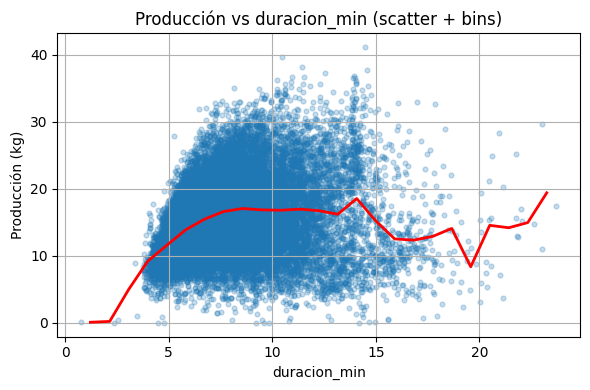

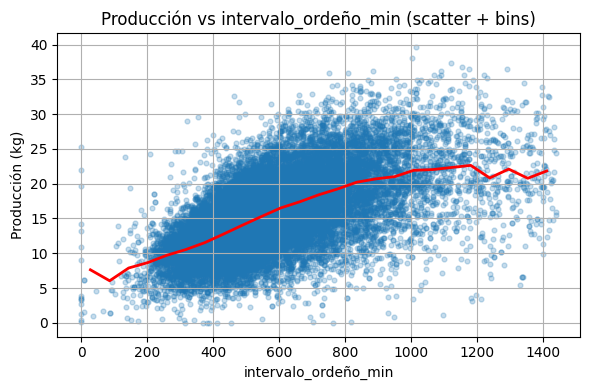

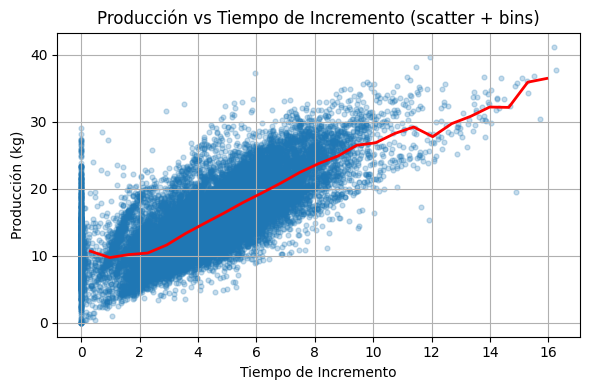

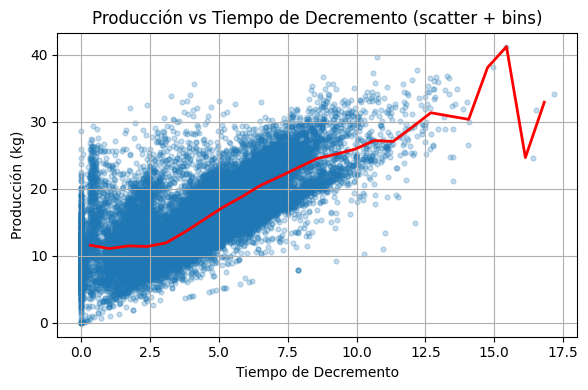

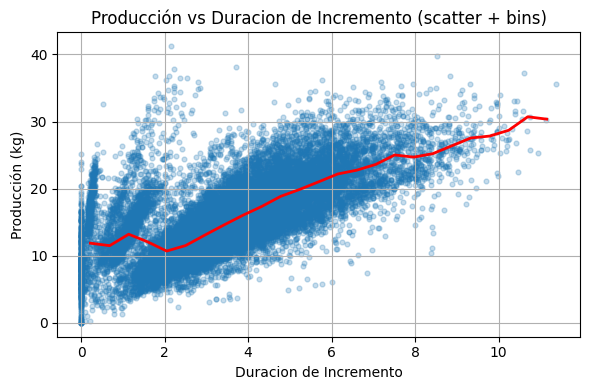

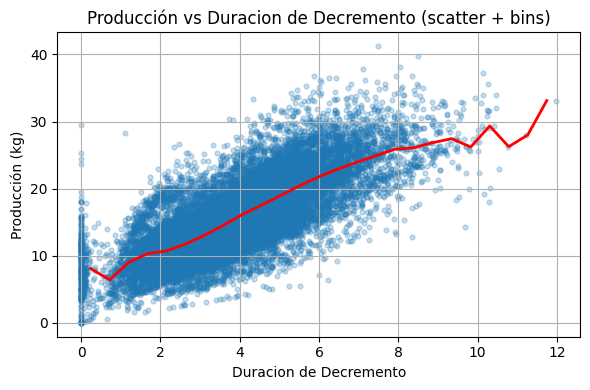

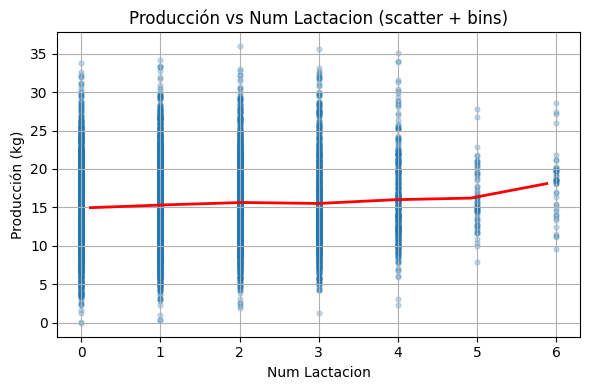

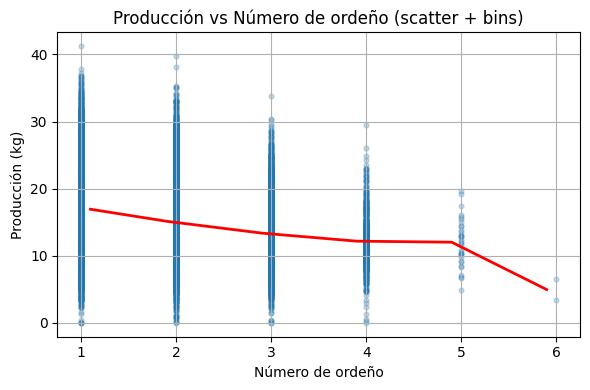

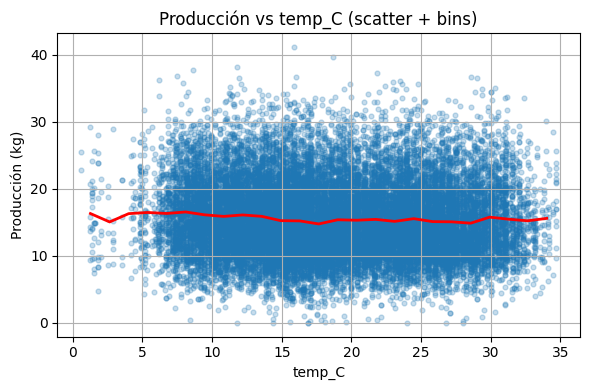

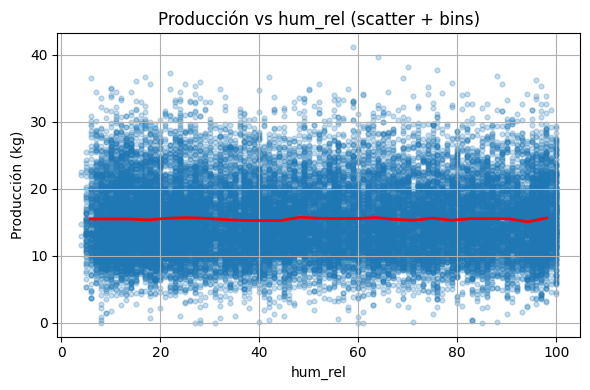

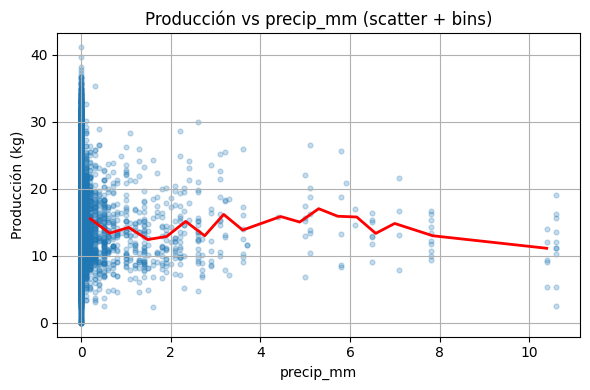

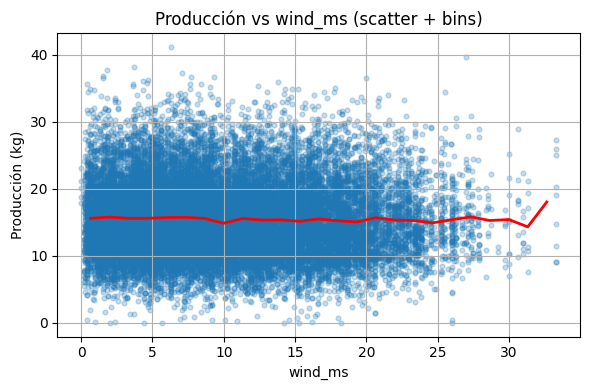

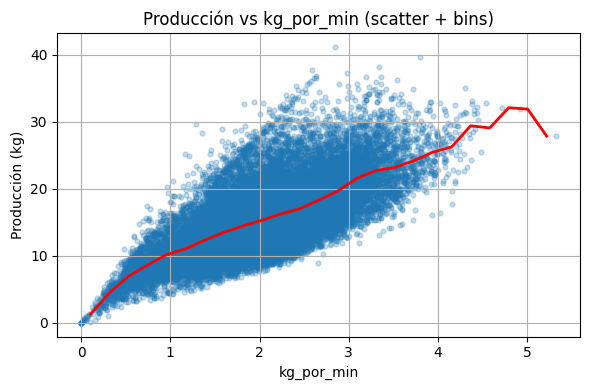

In [36]:
# Variables a graficar (ajusta a tu criterio)
vars_scatter = [
    "duracion_min",
    "intervalo_ordeño_min",
    "Tiempo de Incremento",
    "Tiempo de Decremento",
    "Duracion de Incremento",
    "Duracion de Decremento",
    "Num Lactacion",
    "Número de ordeño",
    "temp_C",
    "hum_rel",
    "precip_mm",
    "wind_ms",
    "kg_por_min",
    # 'is_weekend' suele ser insignificante; si quieres confirmarlo visualmente, descomenta:
    # "is_weekend",
]
vars_scatter = [v for v in vars_scatter if v in df.columns]

plot_df = df.loc[mask, vars_scatter + [target_col]].replace([np.inf, -np.inf], np.nan)

def binned_curve(x, y, bins=20):
    """Curva de respuesta por bins (media por bin) para interpretación operativa."""
    tmp = pd.DataFrame({"x": x, "y": y}).dropna()
    if len(tmp) < 50:
        return None
    tmp["bin"] = pd.cut(tmp["x"], bins=bins)
    g = tmp.groupby("bin", observed=True)["y"].mean()
    xmid = [iv.mid for iv in g.index]
    return np.array(xmid), g.values

for v in vars_scatter:
    x = plot_df[v]
    yv = plot_df[target_col]
    m = x.notna() & yv.notna()
    if m.sum() < 50:
        continue

    plt.figure(figsize=(6,4))
    plt.scatter(x[m], yv[m], alpha=0.25, s=12)
    out = binned_curve(x[m], yv[m], bins=25)
    if out is not None:
        xm, ym = out
        plt.plot(xm, ym, color="red", linewidth=2)  # tendencia en rojo
    plt.title(f"Producción vs {v} (scatter + bins)")
    plt.xlabel(v)
    plt.ylabel("Producción (kg)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 10) Selección de características (filtrado)

Incluye:
- Umbral de varianza
- Correlación (exploratoria)
- Chi-cuadrado (requiere clases -> discretizamos y)
- ANOVA (F-test) para regresión


In [37]:
from sklearn.feature_selection import VarianceThreshold, chi2, f_regression

# 10.1 Umbral de varianza (sobre X_train_std)
vt = VarianceThreshold(threshold=0.01)
Xtr_vt = vt.fit_transform(X_train_std)
kept_cols_vt = X_train_std.columns[vt.get_support()].tolist()
print("VarThreshold: antes =", X_train_std.shape[1], "| después =", len(kept_cols_vt))

# 10.2 Correlación (sobre train, numéricas)
train_corr = pd.concat([X_train_safe.select_dtypes(include=[np.number]), y_train.reset_index(drop=True)], axis=1).corr(numeric_only=True)[target_col]
train_corr = train_corr.drop(labels=[target_col], errors="ignore").sort_values(ascending=False)
print("Top corr +:", train_corr.head(10).to_dict())
print("Top corr -:", train_corr.tail(10).to_dict())

# 10.3 Chi2 (para dependencia feature->clase). En regresión discretizamos y.
y_train_bins = pd.qcut(y_train, q=3, labels=["baja","media","alta"])
chi2_vals, p_vals = chi2(X_train_mm, y_train_bins)
chi2_df = pd.DataFrame({"feature": X_train_mm.columns, "chi2": chi2_vals, "p_value": p_vals}).sort_values("chi2", ascending=False)
chi2_df.head(15)


VarThreshold: antes = 94 | después = 59
Top corr +: {'doy_cos': 0.011998945095984757, 'precip_mm': 0.009772512613225266, 'Duracion de Decremento': 0.008998780418943036, 'Número de ordeño': 0.005755898790706183, 'duracion_min': 0.005186981720141894, 'duracion_s': 0.005186981720141762, 'hour': 0.005131726944562758, 'wind_ms': 0.0038633314524595605, 'pres_msl': 0.003081376991925906, 'Duracion de Incremento': 0.002961051361007332}
Top corr -: {'intervalo_ordeño_min': -0.002809986604366521, 'Tiempo de Decremento': -0.006007338138735388, 'Tiempo de Incremento': -0.006680939632503837, 'Num Lactacion': -0.006932054781941066, 'dec_ratio': -0.007117488359739145, 'doy_sin': -0.007415784969629889, 'month': -0.00795140246008637, 'hour_cos': -0.008913717011628365, 'inc_ratio': -0.009464609636359565, 'dayofyear': -0.01134320549639385}


,feature,chi2,p_value
83,"duracion_bin_q_(0.766, 5.917]",1423.597280,7.409322e-310
6,Tiempo de Decremento,528.336910,1.875416e-115
3,Duracion de Incremento,523.217136,2.425731e-114
4,Duracion de Decremento,482.227360,1.930453e-105
5,Tiempo de Incremento,472.412381,2.611890e-103
23,kg_por_min,412.587593,2.557070e-90
86,"duracion_bin_q_(8.033, 9.767]",315.405920,3.239476e-69
2,intervalo_ordeño_min,287.655358,3.439005e-63
25,dec_ratio,244.675721,7.401882e-54
7,Ubre,235.625168,6.833525e-52


In [38]:
# 10.4 ANOVA / F-test para regresión (requiere X sin NaN)
F, p = f_regression(X_train_std, y_train)
anova_df = pd.DataFrame({"feature": X_train_std.columns, "F": F, "p_value": p}).sort_values("F", ascending=False)
anova_df.head(15)


,feature,F,p_value
4,Duracion de Decremento,26752.632701,0.000000e+00
5,Tiempo de Incremento,22316.412969,0.000000e+00
6,Tiempo de Decremento,20639.627085,0.000000e+00
23,kg_por_min,18511.831683,0.000000e+00
3,Duracion de Incremento,15650.312905,0.000000e+00
2,intervalo_ordeño_min,10278.279894,0.000000e+00
24,inc_ratio,7394.374360,0.000000e+00
25,dec_ratio,6347.356064,0.000000e+00
83,"duracion_bin_q_(0.766, 5.917]",1766.252052,0.000000e+00
8,Número de ordeño,1523.393986,0.000000e+00


## 11) Extracción de características: PCA y Factor Analysis (FA)

**Justificación:** reducir dimensionalidad, multicolinealidad y costo computacional manteniendo información (PCA) o factores latentes (FA).


In [39]:
from sklearn.decomposition import PCA, FactorAnalysis

# PCA (95% varianza) sobre X_train_std
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
Xtr_pca = pca.fit_transform(X_train_std)
Xte_pca = pca.transform(X_test_std)
print("Componentes PCA:", Xtr_pca.shape[1], "| Varianza acum:", float(pca.explained_variance_ratio_.sum()))


Componentes PCA: 23 | Varianza acum: 0.9502879172553753


In [ ]:
# Factor Analysis: elegir un número razonable de factores (heurística)
n_factors = min(10, X_train_std.shape[1])
fa = FactorAnalysis(n_components=n_factors, random_state=RANDOM_SEED)
Xtr_fa = fa.fit_transform(X_train_std)
Xte_fa = fa.transform(X_test_std)
print("Factores FA:", Xtr_fa.shape[1])


## 12) Baseline de modelos (validación rápida)

**Justificación:** aunque el foco es Data Preparation, un baseline confirma señal y permite comparar representaciones.

Evaluamos:
- Ridge (std)
- Ridge (PCA)
- RandomForest (safe)
- Ridge (solo controlables) — **enfoque de optimización**


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

def eval_reg(model, Xtr, Xte, ytr, yte, name):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    mae = mean_absolute_error(yte, pred)
    r2 = r2_score(yte, pred)
    print(f"{name:>24} | MAE={mae:.4f} | R2={r2:.4f}")
    return mae, r2

ridge = Ridge(alpha=1.0, random_state=RANDOM_SEED)
eval_reg(ridge, X_train_std, X_test_std, y_train, y_test, "Ridge (std)")
eval_reg(ridge, Xtr_pca, Xte_pca, y_train, y_test, "Ridge (PCA)")

rf = RandomForestRegressor(n_estimators=400, random_state=RANDOM_SEED, n_jobs=-1)
eval_reg(rf, X_train_safe, X_test_safe, y_train, y_test, "RF (safe)")

# Solo controlables (más interpretable para optimización)
if X_control_train_std.shape[1] >= 1:
    eval_reg(ridge, X_control_train_std, X_control_test_std, y_train, y_test, "Ridge (controlables)")
else:
    print("No hay suficientes variables controlables disponibles para entrenar Ridge(controlables).")


             Ridge (std) | MAE=0.4040 | R2=0.9894
             Ridge (PCA) | MAE=0.7947 | R2=0.9553
               RF (safe) | MAE=0.2724 | R2=0.9916
    Ridge (controlables) | MAE=0.7680 | R2=0.9533


## 13) Conclusiones — CRISP-ML (Data Preparation)

1) Se estandarizaron timestamps y se integró clima por hora (enrichment).  
2) Se generaron features de eficiencia/dinámica (kg/min, ratios) y temporales cíclicas.  
3) Se aplicó binning para insights operativos.  
4) Se codificaron categóricas con one-hot y frequency encoding.  
5) Se implementó un preprocesamiento robusto (imputación + eliminación de columnas vacías/constantes + escalamiento).  
6) Se aplicaron filtros (varianza, correlación, chi2, ANOVA) y extracción (PCA, FA).  

**Hallazgo de relevancia:** variables de calendario como `is_weekend` suelen resultar **insignificantes** en este dominio (operación estandarizada). Por ello se excluyó `is_weekend` del set de entrenamiento final para reducir ruido y dimensionalidad, manteniendo representaciones cíclicas (`hour_sin/cos`) más informativas.

**Siguiente paso (Modeling/Optimization):**
- Interpretabilidad enfocada en **variables controlables** (palancas) y búsqueda de “sweet spots” (p.ej., duración óptima) con restricciones operativas.


## 14) Export (opcional)

Exporta el dataset engineered para usar en la siguiente fase.


In [ ]:
engineered = X.copy()
engineered[target_col] = y

OUT = Path("../data/Features.csv")
engineered.to_csv(OUT, index=False)
print("Exportado:", OUT, "| shape:", engineered.shape)
engineered.head()


Exportado: ../data/Features.csv | shape: (24233, 96)


,duracion_s,duracion_min,intervalo_ordeño_min,Duracion de Incremento,Duracion de Decremento,Tiempo de Incremento,Tiempo de Decremento,Ubre,Pezón,Número de ordeño,Num Lactacion,hour,dow,month,dayofyear,hour_sin,hour_cos,doy_sin,doy_cos,temp_C,hum_rel,pres_msl,precip_mm,wind_ms,kg_por_min,inc_ratio,dec_ratio,Destino Leche_Divert 3,Destino Leche_Dr,Destino Leche_Drenaje,Destino Leche_Ta,Destino Leche_Tanque,Destino Leche_nan,Tipo de evento_Aborto,Tipo de evento_Cambio ID,Tipo de evento_Cambio ID Tran,Tipo de evento_Cambio de grup,Tipo de evento_Cambio de medi,Tipo de evento_Cambio tabla ali,Tipo de evento_Celo,Tipo de evento_Cita de vacunaci,Tipo de evento_Condición corpo,Tipo de evento_Control de Gest,Tipo de evento_Diagnósticos/Tr,Tipo de evento_Entrada,Tipo de evento_Inseminación,Tipo de evento_Invitación Visita,Tipo de evento_Notas,Tipo de evento_Parto,Tipo de evento_Peso,Tipo de evento_Revisión del est,Tipo de evento_Secado,Tipo de evento_Temperatura Re,Tipo de evento_nan,MS_VM,MS_VMS 1,MS_VMS 2,MS_VMS 3,MS_nan,Usuario_nan,Usuario.1_Admin,Usuario.1_Alfredo,Usuario.1_DR RAFA (,Usuario.1_DelproClien,Usuario.1_Dra Guadal,Usuario.1_Dra. Vázqu,Usuario.1_Gabriel,Usuario.1_Jorge,Usuario.1_Jose Luis,Usuario.1_Jose Zapat,Usuario.1_MVZ. GUA,Usuario.1_Matías,Usuario.1_Rodrigo,Usuario.1_Roma,Usuario.1_UnknownBr,Usuario.1_User1,Usuario.1_mvz LUIS Z,Usuario.1_mvz juan,Usuario.1_nan,Programa de lavado_Local Aclarado,Programa de lavado_nan,Razón de la desviación_Sangre por pezón por encima del umbral,Razón de la desviación_Separada manualmente,Razón de la desviación_nan,"duracion_bin_q_(0.766, 5.917]","duracion_bin_q_(5.917, 6.9]","duracion_bin_q_(6.9, 8.033]","duracion_bin_q_(8.033, 9.767]","duracion_bin_q_(9.767, 23.717]",duracion_bin_q_nan,"temp_bin_(0.0, 10.0]","temp_bin_(10.0, 20.0]","temp_bin_(20.0, 30.0]","temp_bin_(30.0, 40.0]",temp_bin_nan,Producción (kg)
0,513.0,8.550000,603.0,4.67,4.42,3.39,5.55,0.0,NaN,1,NaN,0,2,1,1,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.108772,0.006608,0.010819,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,18.03
1,470.0,7.833333,481.0,3.61,NaN,6.82,7.33,0.0,NaN,1,NaN,0,2,1,1,0.0,1.0,0.017166,0.999853,11.6,47.0,1019.2,0.0,8.5,2.267234,0.014511,0.015596,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,17.76
2,369.0,6.150000,572.0,4.52,4.72,6.62,6.49,0.0,NaN,1,3.0,0,2,1,1,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,3.634146,0.017940,0.017588,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,22.35
3,791.0,13.183333,NaN,3.91,4.53,5.48,0.00,0.0,NaN,1,1.0,0,2,1,1,0.0,1.0,0.017166,0.999853,10.6,52.0,1019.5,0.0,8.9,1.055879,0.006928,0.000000,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,Tr